# Time Unit Digits Analysis

In [1]:
from pathlib import Path
import json

import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg

import biopsykit as bp
from biopsykit.stats import StatsPipeline
from biopsykit.io import load_long_format_csv
from biopsykit.utils.dataframe_handling import multi_xs

from fau_colors import cmaps

import matplotlib.pyplot as plt
import seaborn as sns

from carwatch_analysis.io import load_cortisol_samples_log_times
from carwatch_analysis.datasets import CarWatchDatasetProcessed
from carwatch_analysis.plotting import time_unit_digits_histogram, time_unit_digits_histogram_grid

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties)

theme_kwargs_grid = {"context": "talk", "style": "ticks", "palette": palette, "font_scale": 0.8}
sns.set_theme(**theme_kwargs_grid)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"

export = True

pg.options["round"] = 4

palette

[(0.0, 0.1843137254901961, 0.4235294117647059),
 (0.4666666666666667, 0.6235294117647059, 0.7098039215686275),
 (1.0, 0.7215686274509804, 0.10980392156862745),
 (0.0, 0.6392156862745098, 0.8784313725490196),
 (0.2627450980392157, 0.6901960784313725, 0.16470588235294117),
 (0.7843137254901961, 0.06274509803921569, 0.1803921568627451)]

## Setup Paths

In [3]:
deploy_type = "develop"

In [4]:
# build path to data folder
config_dict = json.load(Path("../../../config.json").open(encoding="utf-8"))
data_path = Path("..").joinpath(config_dict[deploy_type]["base_path"])
data_path

PosixPath('/Users/Richer/Documents/PhD/Projects/HealthPsychology/CARWatch/Data')

In [5]:
dataset = CarWatchDatasetProcessed(data_path)
dataset

,subject,night
0,AB19E,0
1,AB19E,1
2,AB31R,0
3,AB31R,1
4,AC12E,0
...,...,...
229,VE19A,1
230,VS09S,0
231,VS09S,1
232,WM13K,0


In [6]:
base_path = Path("../..")
export_path = base_path.joinpath("exports")
result_path = base_path.joinpath("results")
stats_path = result_path.joinpath("statistics")

img_path = result_path.joinpath("plots")

paper_path = Path(json.load(Path("../paper_path.json").open(encoding="utf-8"))["paper_path"])
paper_img_path = paper_path.joinpath("img")

bp.utils.file_handling.mkdirs([result_path, stats_path, img_path, paper_img_path])

## Load Data

### Cortisol Samples

In [7]:
cort_path = export_path.joinpath("cortisol_samples_processed_all_log_types.csv")
cort_samples = load_cortisol_samples_log_times(cort_path)
# rename condition for
cort_samples = cort_samples.rename({"Spontaneous": "Spontaneous Awakening"}, level="condition")
cort_samples.head()

date      wake_onset  \
subject night night_id condition   log_type sample                              
AB19E   0     AB19E_0  Known Alarm Naive    S0     2019-11-18 0 days 05:45:00   
                                            S1     2019-11-18 0 days 05:45:00   
                                            S2     2019-11-18 0 days 05:45:00   
                                            S3     2019-11-18 0 days 05:45:00   
                                            S4     2019-11-18 0 days 05:45:00   

                                                       sample_time  cortisol  \
subject night night_id condition   log_type sample                             
AB19E   0     AB19E_0  Known Alarm Naive    S0     0 days 05:45:00      2.80   
                                            S1     0 days 06:00:00      5.59   
                                            S2     0 days 06:15:00     13.29   
                                            S3     0 days 06:30:00     13.46   
                                            S4     0 days 06:45:00     12.65   

                                                   time_diff_to_wake_onset  \
subject night night_id condition   log_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive    S0             0 days 00:00:00   
                                            S1             0 days 00:15:00   
                                            S2             0 days 00:30:00   
                                            S3             0 days 00:45:00   
                                            S4             0 days 01:00:00   

                                                    time_diff_min  \
subject night night_id condition   log_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive    S0                0.0   
                                            S1               15.0   
                                            S2               30.0   
                                            S3               45.0   
                                            S4               60.0   

                                                    time_diff_to_naive_min  
subject night night_id condition   log_type sample                          
AB19E   0     AB19E_0  Known Alarm Naive    S0                         0.0  
                                            S1                         0.0  
                                            S2                         0.0  
                                            S3                         0.0  
                                            S4                         0.0

In [8]:
conditions = ["Spontaneous Awakening", "Known Alarm", "Unknown Alarm"]
log_types_fine = [
    "Naive",
    "Selfreport without App",
    "Selfreport with App",
    "App",
    "Sensor + Selfreport without App",
    "Sensor + Selfreport with App",
    "Sensor + App",
]
log_types_coarse = ["Naive", "Selfreport", "App", "Sensor + Selfreport", "Sensor + App"]

In [9]:
dict_unit_digits = {}

## Awakening and Sampling Time Unit Digits

In [10]:
log_type_order = ["Selfreport", "App"]
condition_order = ["Known Alarm", "Spontaneous Awakening", "Unknown Alarm"]

### Data Preparation

In [11]:
cort_samples = cort_samples.assign(
    **{
        "sample_minute": cort_samples["sample_time"].dt.components["minutes"] % 10,
        "wake_onset_minute": cort_samples["wake_onset"].dt.components["minutes"] % 10,
    }
)

cort_samples.head()

date      wake_onset  \
subject night night_id condition   log_type sample                              
AB19E   0     AB19E_0  Known Alarm Naive    S0     2019-11-18 0 days 05:45:00   
                                            S1     2019-11-18 0 days 05:45:00   
                                            S2     2019-11-18 0 days 05:45:00   
                                            S3     2019-11-18 0 days 05:45:00   
                                            S4     2019-11-18 0 days 05:45:00   

                                                       sample_time  cortisol  \
subject night night_id condition   log_type sample                             
AB19E   0     AB19E_0  Known Alarm Naive    S0     0 days 05:45:00      2.80   
                                            S1     0 days 06:00:00      5.59   
                                            S2     0 days 06:15:00     13.29   
                                            S3     0 days 06:30:00     13.46   
                                            S4     0 days 06:45:00     12.65   

                                                   time_diff_to_wake_onset  \
subject night night_id condition   log_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive    S0             0 days 00:00:00   
                                            S1             0 days 00:15:00   
                                            S2             0 days 00:30:00   
                                            S3             0 days 00:45:00   
                                            S4             0 days 01:00:00   

                                                    time_diff_min  \
subject night night_id condition   log_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive    S0                0.0   
                                            S1               15.0   
                                            S2               30.0   
                                            S3               45.0   
                                            S4               60.0   

                                                    time_diff_to_naive_min  \
subject night night_id condition   log_type sample                           
AB19E   0     AB19E_0  Known Alarm Naive    S0                         0.0   
                                            S1                         0.0   
                                            S2                         0.0   
                                            S3                         0.0   
                                            S4                         0.0   

                                                    sample_minute  \
subject night night_id condition   log_type sample                  
AB19E   0     AB19E_0  Known Alarm Naive    S0                  5   
                                            S1                  0   
                                            S2                  5   
                                            S3                  0   
                                            S4                  5   

                                                    wake_onset_minute  
subject night night_id condition   log_type sample                     
AB19E   0     AB19E_0  Known Alarm Naive    S0                      5  
                                            S1                      5  
                                            S2                      5  
                                            S3                      5  
                                            S4                      5

### Awakening Times

#### Percents

In [12]:
wo_minutes = cort_samples["wake_onset_minute"].reindex(log_type_order, level="log_type")
wo_minutes = wo_minutes.groupby(["condition", "log_type"]).value_counts(normalize=True) * 100
wo_minutes = wo_minutes.unstack(["wake_onset_minute"]).fillna(0).round(0)
dict_unit_digits["Awakening_Time_Unit_Digits"] = wo_minutes

wo_minutes

wake_onset_minute                    0     1    2    3     4     5     6  \
condition             log_type                                             
Known Alarm           Selfreport  62.0   2.0  2.0  4.0   4.0  25.0   0.0   
                      App         47.0   6.0  0.0  6.0   6.0  12.0  12.0   
Spontaneous Awakening Selfreport  40.0   3.0  4.0  2.0   3.0  33.0   4.0   
                      App          6.0  15.0  6.0  6.0   6.0  12.0  21.0   
Unknown Alarm         Selfreport  60.0   4.0  2.0  2.0   2.0  17.0   4.0   
                      App          7.0  14.0  0.0  0.0  17.0   3.0  17.0   

wake_onset_minute                    7    8     9  
condition             log_type                     
Known Alarm           Selfreport   0.0  2.0   0.0  
                      App          6.0  6.0   0.0  
Spontaneous Awakening Selfreport   5.0  4.0   1.0  
                      App         18.0  9.0   3.0  
Unknown Alarm         Selfreport   2.0  2.0   4.0  
                      App          0.0  0.0  41.0

#### Histogram Plots

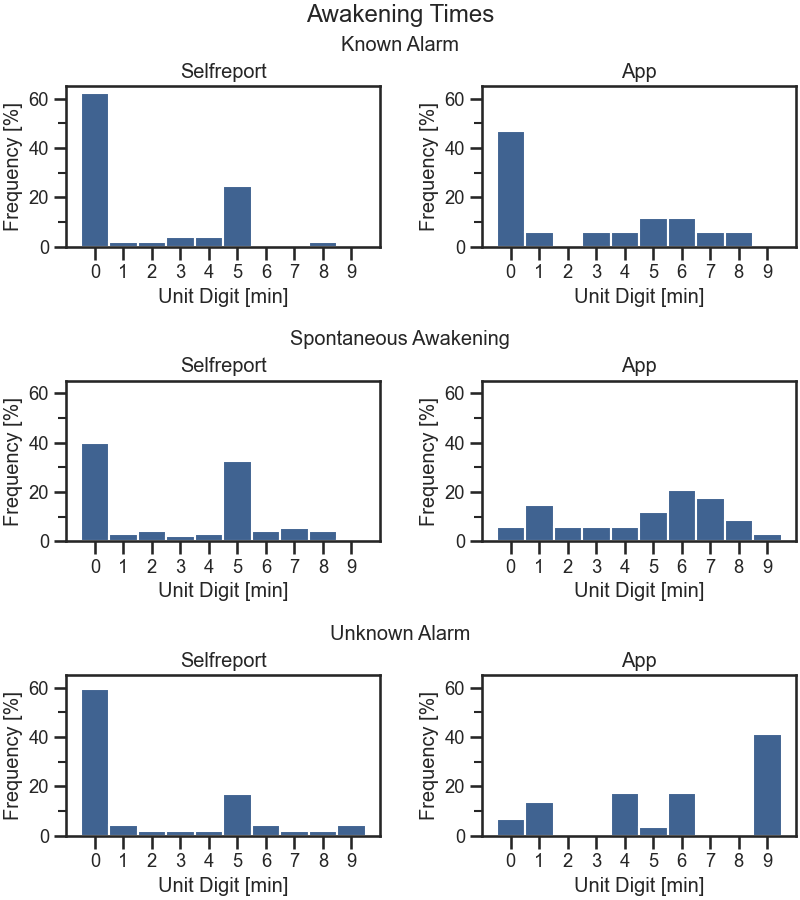

In [13]:
data_analysis = cort_samples.reindex(log_type_order, level="log_type")
x = "wake_onset_minute"
ylim = [0, 65]

fig, axs = time_unit_digits_histogram_grid(
    data=data_analysis,
    x=x,
    condition_order=condition_order,
    log_type_order=log_type_order,
    suptitle="Awakening Times",
    ylim=ylim,
    figsize=(8, 9),
)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_unit_digits_awakening_time", path, ["pdf", "png"], dpi=300)

### Sampling Times

#### Percents

In [14]:
sample_minutes = cort_samples["sample_minute"].reindex(log_type_order, level="log_type")
sample_minutes = sample_minutes.groupby(["log_type"]).value_counts(normalize=True) * 100
sample_minutes = sample_minutes.unstack(["sample_minute"]).fillna(0).round(0)
dict_unit_digits["Sampling_Time_Unit_Digits"] = sample_minutes

sample_minutes

sample_minute,0,1,2,3,4,5,6,7,8,9
log_type,,,,,,,,,,
Selfreport,24.0,9.0,8.0,7.0,4.0,21.0,8.0,9.0,7.0,4.0
App,8.0,13.0,12.0,10.0,7.0,9.0,10.0,12.0,12.0,8.0


#### Histogram Plots

##### All Conditions Combined

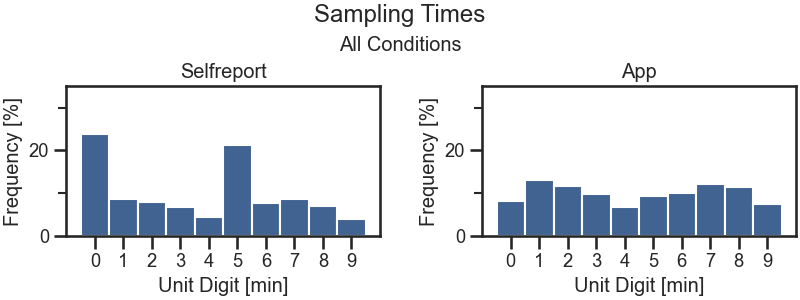

In [15]:
ylim = [0, 35]
data_analysis = cort_samples.reindex(log_type_order, level="log_type")

fig, axs = time_unit_digits_histogram(
    data=data_analysis,
    x="sample_minute",
    log_type_order=log_type_order,
    suptitle="Sampling Times",
    ylim=ylim,
    figsize=(8, 3),
)


for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_unit_digits_sampling_time_combined", path, ["pdf", "png"])

##### Per Condition

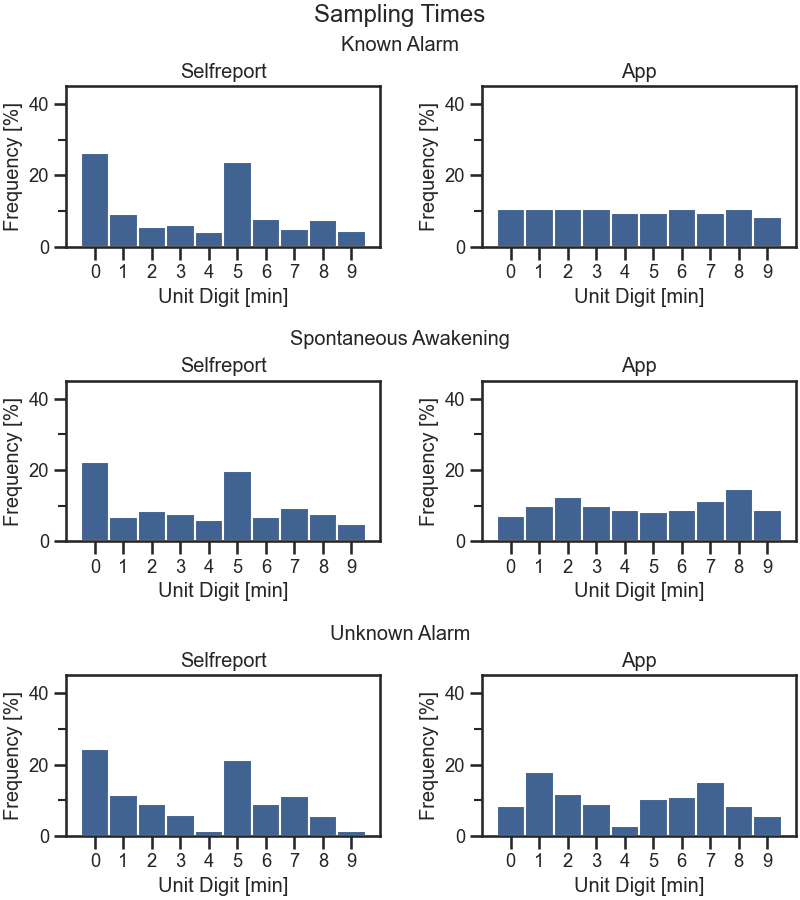

In [16]:
data_analysis = cort_samples.reindex(log_type_order, level="log_type")
x = "sample_minute"
ylim = [0, 45]

fig, axs = time_unit_digits_histogram_grid(
    data=data_analysis,
    x=x,
    condition_order=condition_order,
    log_type_order=log_type_order,
    suptitle="Sampling Times",
    ylim=ylim,
    figsize=(8, 9),
)

for path in [img_path, paper_img_path]:
    bp.utils.file_handling.export_figure(fig, "img_unit_digits_sampling_time", path, ["pdf", "png"])

## Export

In [17]:
bp.io.write_pandas_dict_excel(dict_unit_digits, result_path.joinpath("time_unit_digits_results.xlsx"))